# Basic example

In this example, we showcase the use of `pyshqg`:

1. we first show how to check that the integration unit test is satisfied;
2. then we show how to compute a model trajectory;
3. finally we show how to plot the final state of the trajectory.

Let us start by importing `numpy` and `pyshqg`.
Note that in `pyshqg` we only import what we will actually use.

In [1]:
import numpy as np
from pyshqg.backend.numpy_backend import NumpyBackend as Backend
from pyshqg.core.constructors import construct_model, construct_integrator
from pyshqg.preprocessing.reference_data import load_test_data

## Unit test

Let us define a function to compute the relative root mean squared error (RMSE)
between two vectors.

In [2]:
def relative_rmse(x, y):
    rms_x = np.sqrt(np.mean(np.square(x)))
    rms_y = np.sqrt(np.mean(np.square(y)))
    rms_xy = np.sqrt(np.mean(np.square(x-y)))
    return rms_xy, rms_x, rms_y, 2*rms_xy/(rms_x+rms_y)

We now load the test data at T21 resolution, interpolated in the T31 Gauss--Legendre grid.

In [3]:
ds_test = load_test_data(
    internal_truncature=21,
    grid_truncature=31,
)

`ds_test` is now an `xarray.Dataset` containing the required test data as data variables.

In [4]:
ds_test

<xarray.Dataset> Size: 10MB
Dimensions:             (ensemble: 16, level: 3, lat: 32, lon: 64, c: 2, l: 22,
                         m: 22)
Coordinates:
  * lat                 (lat) float64 256B 85.76 80.27 74.74 ... -80.27 -85.76
  * lon                 (lon) float64 512B 0.0 5.625 11.25 ... 343.1 348.8 354.4
Dimensions without coordinates: ensemble, level, c, l, m
Data variables: (12/21)
    dissip_ekman        (ensemble, level, lat, lon) float64 786kB 0.0 ... -1....
    dpsi_dphi           (ensemble, level, lat, lon) float64 786kB -0.1937 ......
    dpsi_dtheta         (ensemble, level, lat, lon) float64 786kB -0.02461 .....
    dq_dphi             (ensemble, level, lat, lon) float64 786kB 1.216e-12 ....
    dq_dtheta           (ensemble, level, lat, lon) float64 786kB -1.245e-13 ...
    forcing             (level, lat, lon) float64 49kB -7e-11 ... -1.593e-10
    ...                  ...
    spec_q              (ensemble, level, c, l, m) float64 372kB -5.365e-07 ....
    spec_rk2            (ensemble, level, c, l, m) float64 372kB -5.364e-07 ....
    spec_rk4            (ensemble, level, c, l, m) float64 372kB -5.364e-07 ....
    spec_tendencies     (ensemble, level, c, l, m) float64 372kB 2.901e-16 .....
    spec_total_q        (ensemble, level, c, l, m) float64 372kB -5.365e-07 ....
    zeta                (ensemble, lat, lon) float64 262kB 3.467e-06 ... -2.8...
Attributes:
    config:   {'abm_integration': {'dt': 1800, 'method': 'abm'}, 'data_interp...

Next, we create a model and the associated fourth-order Runge--Kutta integrator
using the configuration encapsulated in the test data attribute `config`.
Note that, in order to create the model, we need a backend.
Here, we use the standard `numpy`-based backend with double precision, i.e. with `floatx = 'float64'`.

In [5]:
backend = Backend(floatx='float64')
model = construct_model(backend, ds_test.config)
rk4 = construct_integrator(ds_test.config['rk4_integration'], model)

Finally, we create a model state using variable `spec_q` of `ds_test`, which contains the vorticity in spectral space.

In [6]:
state = model.model_state(ds_test.spec_q.to_numpy())

`state` is now a dictionnary, containing only the spectral vorticity at key `'spec_q'`.

In [7]:
print(type(state))
print(state.keys())

<class 'dict'>
dict_keys(['spec_q'])


The spectral vorticity is a numpy array of shape `(Ne, Nz, 2, T+1, T+1)` where

- `Ne = 16` is the ensemble size;
- `Nz = 3` is the number of vertical levels;
- `(2, T+1, T+1) = (2, 22, 22)` correspond to the spectral coefficients.

In [8]:
print(type(state['spec_q']))
print(state['spec_q'].shape)

<class 'numpy.ndarray'>
(16, 3, 2, 22, 22)


It is now time to run one integration step, using the `forward()` method of the integrator.

In [9]:
fwd_state = rk4.forward(state)

We compare the obtained integrated state to the test data using the relative RMSE.
The result is lower than $10^{-9}$, hence we conclude that our integration should
be correct.

In [10]:
rms = relative_rmse(
    backend.to_numpy(fwd_state['spec_q']),
    ds_test.spec_rk4.to_numpy(),
)

print(f"RMS of fwd_state['spec_q']: {rms[1]:.4e}")
print(f"RMS of ds_test.spec_rk4   : {rms[2]:.4e}")
print(f"RMS error                 : {rms[0]:.4e}")
print(f"RMS error [relative]      : {rms[3]:.4e}")

RMS of fwd_state['spec_q']: 4.2355e-06
RMS of ds_test.spec_rk4   : 4.2355e-06
RMS error                 : 7.4632e-16
RMS error [relative]      : 1.7621e-10


## Example model integration

Next, we use the model integrator to compute a full trajectory, using the `run()` method of the integrator,
where we need to specify:

- the starting time (in model time unit) `t_start = 0`;
- the number of snapshots to compute `num_snapshots = 8`;
- the number of integration steps between two snapshots `num_steps_per_snapshot = 10`;
- the list of variables to record (`variables`).

In [11]:
state = model.model_state(ds_test.spec_q.to_numpy())
trajectory = rk4.run(
    state,
    t_start=0,
    num_snapshots=8,
    num_steps_per_snapshot=10,
    variables=('spec_q', 'spec_psi', 'zeta', 'q', 'psi'),
)

model integration:   0%|          | 0/8 [00:00<?, ?it/s]

The result is a `pyshqg.core.model.QGModelTrajectory` instance.

In [12]:
print(type(trajectory))

<class 'pyshqg.core.model.QGModelTrajectory'>


This object can be converted into a dictionnary of numpy arrays
or directly into an `xarray.Dataset` as follows:

In [13]:
trajectory_xr = trajectory.to_xarray()
trajectory_xr

<xarray.Dataset> Size: 23MB
Dimensions:   (time: 9, batch: 16, level: 3, c: 2, l: 22, m: 22, lat: 32,
               lon: 64)
Coordinates:
  * time      (time) int64 72B 0 18000 36000 54000 ... 108000 126000 144000
  * lat       (lat) float64 256B -85.76 -80.27 -74.74 ... 74.74 80.27 85.76
  * lon       (lon) float64 512B 180.0 185.6 191.2 196.9 ... 163.1 168.8 174.4
Dimensions without coordinates: batch, level, c, l, m
Data variables:
    spec_q    (time, batch, level, c, l, m) float64 3MB -5.365e-07 ... -1.223...
    spec_psi  (time, batch, level, c, l, m) float64 3MB 0.0 0.0 ... 285.9 322.0
    zeta      (time, batch, lat, lon) float64 2MB 3.467e-06 ... -1.455e-05
    q         (time, batch, level, lat, lon) float64 7MB -0.000298 ... -0.000...
    psi       (time, batch, level, lat, lon) float64 7MB 1.445e+08 ... -1.38e+07

## Plot the result

Finally, let us plot the stream function $\psi$ at the end of the simulation (`time = -1`) 
for the first ensemble ensemble member (`batch  =0`). We show only the lowest level (`level = -1`).

Note that the plot is drawn using `matplotlib`. We use `cartopy` to map the latitude-longitude
coordinates into the figure for a given projection (`ccrs.Robinson` here). Also note that we use
one of the perceptually uniform colormap from the package `cmocean`.

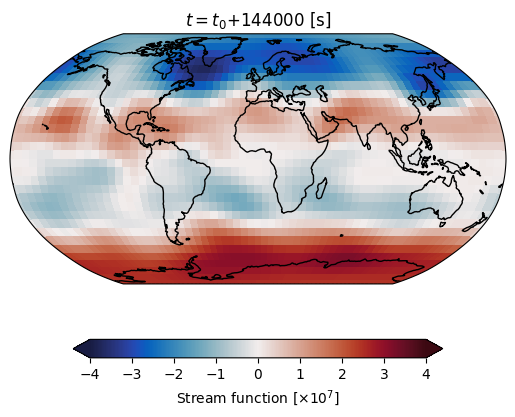

In [14]:
# TODO: include unit for the stream function
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.Robinson())

lon = trajectory_xr.lon.to_numpy()
lat = trajectory_xr.lat.to_numpy()
psi = trajectory_xr.psi.isel(time=-1, batch=0, level=-1).to_numpy() / 1e7
time = trajectory_xr.time.to_numpy()[-1]

ax.set_title(f'$t=t_0$+{time} [s]')
im = ax.pcolormesh(
    lon,
    lat,
    psi,
    cmap=cmocean.cm.balance,
    vmin=-4,
    vmax=4,
    transform=ccrs.PlateCarree(),
)
ax.coastlines()
plt.colorbar(
    im,
    orientation='horizontal',
    extend='both',
    fraction=0.05,
    shrink=0.75,
    label='Stream function [$\\times 10^{7}$]',
)
plt.show()